# 🚀 First Challenge Question
In this problem, you will use the MobileNet pre-defined model from PyTorch to train on the CIFAR-100 dataset. You will explore the effects of various optimizers on the model’s performance.

**Compare the performance of different optimization algorithms while training the MobileNet model on the CIFAR-100 dataset.**

Use the following optimizers:


*   SGD
*   SGD + momentum
*   RMSprop
*   Adadelta
*   Adagrad
*   Adam

**To increase the speed, it is recommended to write the training loop as a function and use it. Make sure that the necessary variables, especially the model, are redefined for each experiment.**



Please consider the steps and fill *#TODO* sections.

For more information, please refer to the following resources.

(Having information about MobilenetV2 architecture is necessary)

- https://www.kaggle.com/discussions/getting-started/433540
- https://paperswithcode.com/method/mobilenetv2
- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
- https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c
## Task

<h1>Version 1</h1>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import models

In [ ]:
# Define the device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE}')


Using device: cuda


In [ ]:
# Load the CIFAR-100 dataset, resize them to 224 and convert them to tensor
transform = transforms.Compose(
    [
        transforms.Resize(224),  # Resize images to 224x224
        transforms.ToTensor(),   # Convert images to tensor
        transforms.Normalize((0.485, 0.456, 0.406),  # Normalize with ImageNet means
                             (0.229, 0.224, 0.225))  # Normalize with ImageNet stds
    ]
)

In [ ]:
# Define dataset and dataloader objects. Set batch_size to 32, just shuffle train data.

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_mobilenetv2_model():
    mobilenet = models.mobilenet_v2(pretrained=False)  # Don't use pre-trained weights
    num_ftrs = mobilenet.classifier[1].in_features
    mobilenet.classifier[1] = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    mobilenet = mobilenet.to(DEVICE)
    return mobilenet

In [ ]:
# Define a dictionary of optimizers with their corresponding parameters
optimizers_dict = {
    'SGD': {'optimizer': optim.SGD, 'params': {'lr': 0.01}},
    'SGD_Momentum': {'optimizer': optim.SGD, 'params': {'lr': 0.01, 'momentum': 0.9}},
    'RMSprop': {'optimizer': optim.RMSprop, 'params': {'lr': 0.001, 'alpha': 0.99}},
    'Adadelta': {'optimizer': optim.Adadelta, 'params': {'lr': 1.0, 'rho': 0.9}},
    'Adagrad': {'optimizer': optim.Adagrad, 'params': {'lr': 0.01}},
    'Adam': {'optimizer': optim.Adam, 'params': {'lr': 0.001, 'betas': (0.9, 0.999)}}
}

In [1]:
# Lists to store results for all optimizers
results = []

# Iterate through each optimizer and train the model
for opt_name, opt_info in optimizers_dict.items():
    print(f'\nTraining with optimizer: {opt_name}')

    # Initialize the model
    mobilenet = get_mobilenetv2_model()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = opt_info['optimizer'](mobilenet.parameters(), **opt_info['params'])

    # Lists to store loss and accuracy for this optimizer
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Record the start time
    start_time = time.time()

    # Training loop
    for epoch in range(7):  # Adjust the number of epochs as needed
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        mobilenet.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # move data to device
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # zero the gradients
            optimizer.zero_grad()

            # Get the outputs
            outputs = mobilenet(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # Update weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        mobilenet.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # made network creates no gradients
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = mobilenet(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # find the predicted classes
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                # Calculate the correctness
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.3f}, '
              f'Val Loss: {val_losses[-1]:.3f}, '
              f'Train Acc: {train_accuracies[-1]:.2f}%, '
              f'Val Acc: {val_accuracies[-1]:.2f}%')

    print('Finished Training')

    # Record the end time
    end_time = time.time()
    total_time = end_time - start_time

    # Evaluate the model on the test set and calculate the acc.
    correct_final = 0
    total_final = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_final += labels.size(0)
            correct_final += (predicted == labels).sum().item()

    final_accuracy = 100 * correct_final / total_final
    print(f'Accuracy of the network on the test images: {final_accuracy:.2f} %')

    # Store the results for this optimizer
    result = {
        'Optimizer': opt_name,
        'Val Loss Epoch 1': val_losses[0],
        'Val Acc Epoch 1 (%)': val_accuracies[0],
        'Val Loss Epoch 5': val_losses[4],
        'Val Acc Epoch 5 (%)': val_accuracies[4],
        'Val Loss Epoch 10': val_losses[9],
        'Val Acc Epoch 10 (%)': val_accuracies[9],
        'Total Training Time (s)': round(total_time, 2)
    }
    results.append(result)


In [ ]:
# Create a DataFrame to display the comparison of optimizers
results_df = pd.DataFrame(results)
print("\nComparison of Optimizers:")
print(results_df)

# Plotting loss and accuracy for each optimizer
# We'll plot Val Loss and Val Accuracy after each epoch for all optimizers

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for result in results:
    optimizer_name = result['Optimizer']
    val_loss_epoch_1 = result['Val Loss Epoch 1']
    val_loss_epoch_5 = result['Val Loss Epoch 5']
    val_loss_epoch_10 = result['Val Loss Epoch 10']
    plt.plot([1, 5, 10], [val_loss_epoch_1, val_loss_epoch_5, val_loss_epoch_10], marker='o', label=optimizer_name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for result in results:
    optimizer_name = result['Optimizer']
    val_acc_epoch_1 = result['Val Acc Epoch 1 (%)']
    val_acc_epoch_5 = result['Val Acc Epoch 5 (%)']
    val_acc_epoch_10 = result['Val Acc Epoch 10 (%)']
    plt.plot([1, 5, 10], [val_acc_epoch_1, val_acc_epoch_5, val_acc_epoch_10], marker='o', label=optimizer_name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set and calculate the acc.
# (Already done above for each optimizer, but if you need to do it again, uncomment below)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


<h1>Version 2<h1>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchvision import models


In [ ]:
# Define the device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
# Create a directory to save results if it doesn't exist
if not os.path.exists('optimizer_results'):
    os.makedirs('optimizer_results')

In [ ]:
# Load the CIFAR-100 dataset, resize them to 224 and convert them to tensor
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224
    transforms.ToTensor(),   # Convert images to tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # Normalize with ImageNet means
                         (0.229, 0.224, 0.225))  # Normalize with ImageNet stds
])

In [ ]:
# Define dataset and dataloader objects. Set batch_size to 32, just shuffle train data.
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_mobilenetv2_model():
    mobilenet = models.mobilenet_v2(pretrained=False)  # Don't use pre-trained weights
    num_ftrs = mobilenet.classifier[1].in_features
    mobilenet.classifier[1] = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    mobilenet = mobilenet.to(DEVICE)
    return mobilenet

In [ ]:
def train_model(optimizer_name, optimizer_info, num_epochs=10):
    print(f'\nTraining with optimizer: {optimizer_name}')

    # Initialize the model
    mobilenet = get_mobilenetv2_model()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = optimizer_info['optimizer'](mobilenet.parameters(), **optimizer_info['params'])

    # Lists to store loss and accuracy for this optimizer
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Record the start time
    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):  # Adjust the number of epochs as needed
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        mobilenet.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Move data to device
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Get the outputs
            outputs = mobilenet(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Display progress every 10%
            if (i + 1) % max(1, len(trainloader) // 10) == 0:
                progress = (i + 1) / len(trainloader) * 100
                print(f"Progress: {progress:.1f}% completed for this epoch")

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        mobilenet.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = mobilenet(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Find the predicted classes
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                # Calculate the correctness
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.3f}, '
              f'Val Loss: {val_losses[-1]:.3f}, '
              f'Train Acc: {train_accuracies[-1]:.2f}%, '
              f'Val Acc: {val_accuracies[-1]:.2f}%')

    print('Finished Training')

    # Record the end time
    end_time = time.time()
    total_time = end_time - start_time
    print(f'Total Training Time: {total_time:.2f} seconds')

    # Evaluate the model on the test set and calculate the accuracy
    correct_final = 0
    total_final = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_final += labels.size(0)
            correct_final += (predicted == labels).sum().item()

    final_accuracy = 100 * correct_final / total_final
    print(f'Accuracy of the network on the test images: {final_accuracy:.2f} %')

    # Store the results for this optimizer
    result = {
        'Optimizer': optimizer_name,
        'Val Loss Epoch 1': val_losses[0],
        'Val Acc Epoch 1 (%)': val_accuracies[0],
        'Val Loss Epoch 5': val_losses[4] if num_epochs >=5 else 'N/A',
        'Val Acc Epoch 5 (%)': val_accuracies[4] if num_epochs >=5 else 'N/A',
        'Val Loss Epoch 10': val_losses[9] if num_epochs >=10 else 'N/A',
        'Val Acc Epoch 10 (%)': val_accuracies[9] if num_epochs >=10 else 'N/A',
        'Total Training Time (s)': round(total_time, 2)
    }

    # Save individual optimizer results to a CSV file
    results_df = pd.DataFrame([result])
    results_file = 'optimizer_results/results.csv'
    if os.path.exists(results_file):
        results_df.to_csv(results_file, mode='a', header=False, index=False)
    else:
        results_df.to_csv(results_file, mode='w', header=True, index=False)

    print(f'Results saved for optimizer: {optimizer_name}')

    return result


In [ ]:
# Define a dictionary of optimizers with their corresponding parameters
optimizers_dict = {
    'SGD': {'optimizer': optim.SGD, 'params': {'lr': 0.01}},
    'SGD_Momentum': {'optimizer': optim.SGD, 'params': {'lr': 0.01, 'momentum': 0.9}},
    'RMSprop': {'optimizer': optim.RMSprop, 'params': {'lr': 0.001, 'alpha': 0.99}},
    'Adadelta': {'optimizer': optim.Adadelta, 'params': {'lr': 1.0, 'rho': 0.9}},
    'Adagrad': {'optimizer': optim.Adagrad, 'params': {'lr': 0.01}},
    'Adam': {'optimizer': optim.Adam, 'params': {'lr': 0.001, 'betas': (0.9, 0.999)}}
}



Training with optimizer: SGD

Epoch 1/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 4.196, Val Loss: 3.893, Train Acc: 5.44%, Val Acc: 9.45%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 3.627, Val Loss: 3.408, Tra

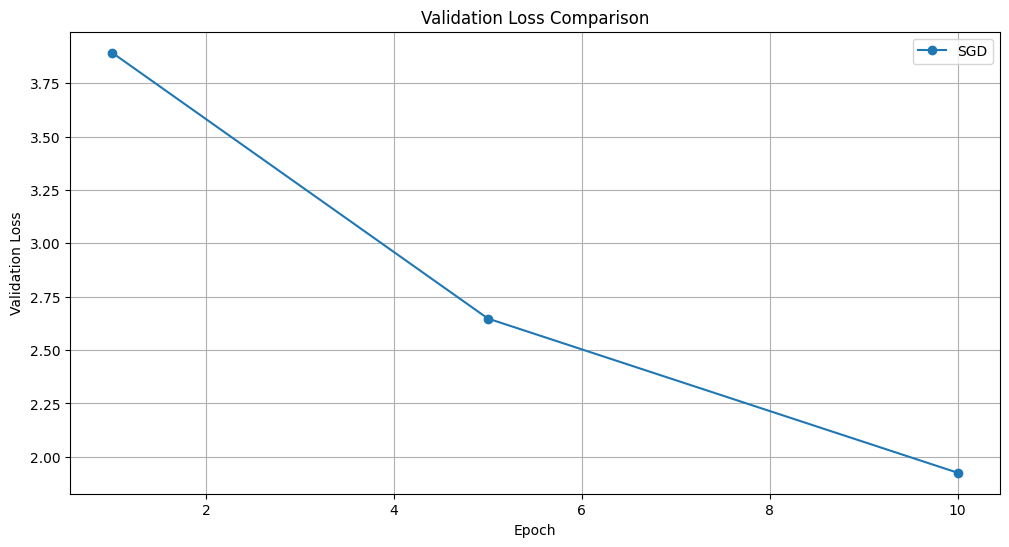

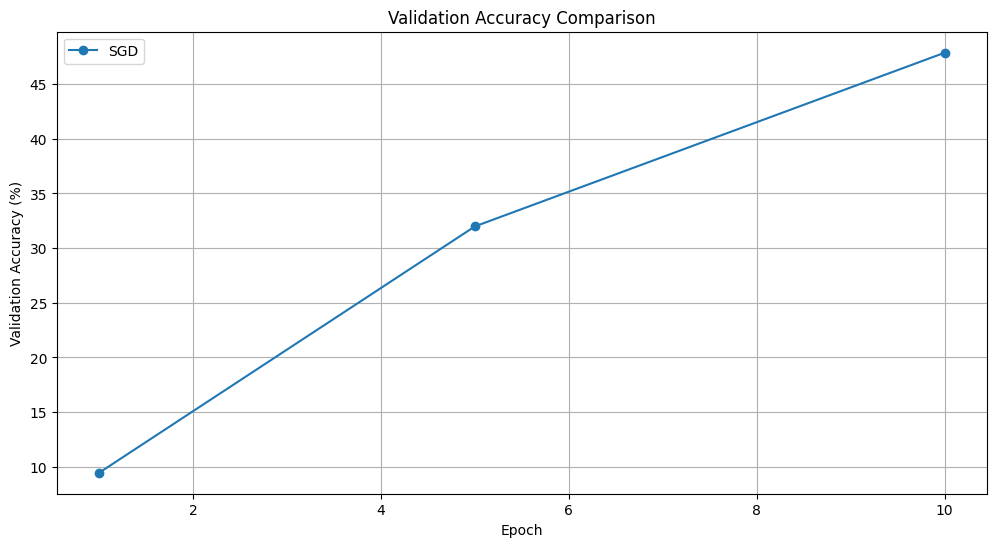

In [ ]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['SGD']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Training with optimizer: SGD_Momentum

Epoch 1/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 3.784, Val Loss: 3.168, Train Acc: 12.40%, Val Acc: 22.86%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 2.797, Val Loss:

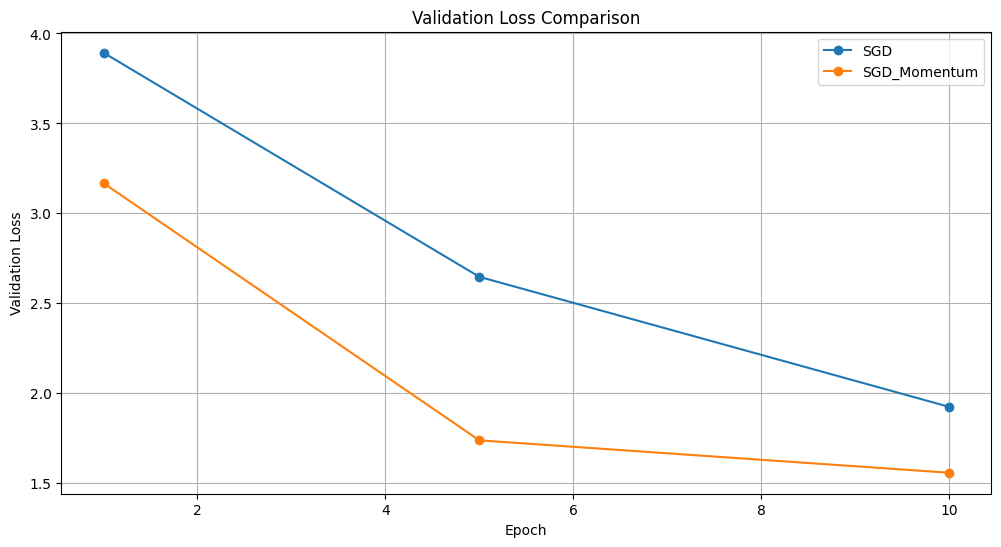

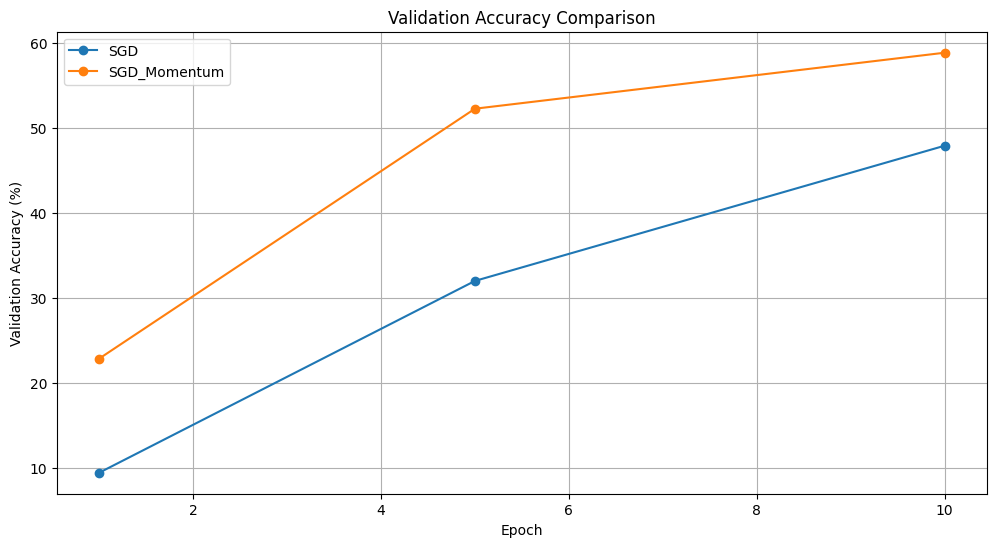

In [ ]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['SGD_Momentum']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Training with optimizer: RMSprop

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 3.841, Val Loss: 3.354, Train Acc: 9.35%, Val Acc: 15.43%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 3.004, Val Loss: 2.734, Train Acc: 22.85%, Val Acc: 28.12%

Epoch 3/

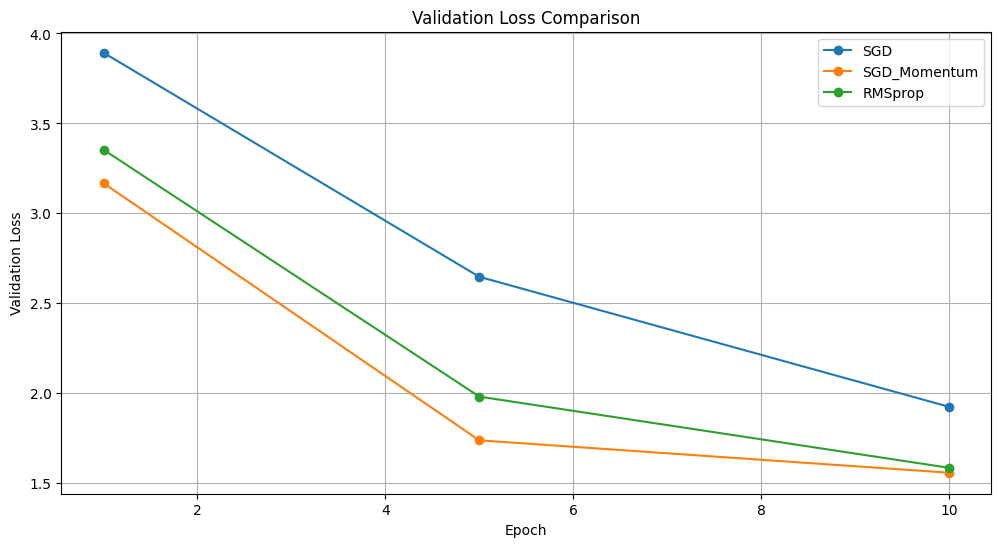

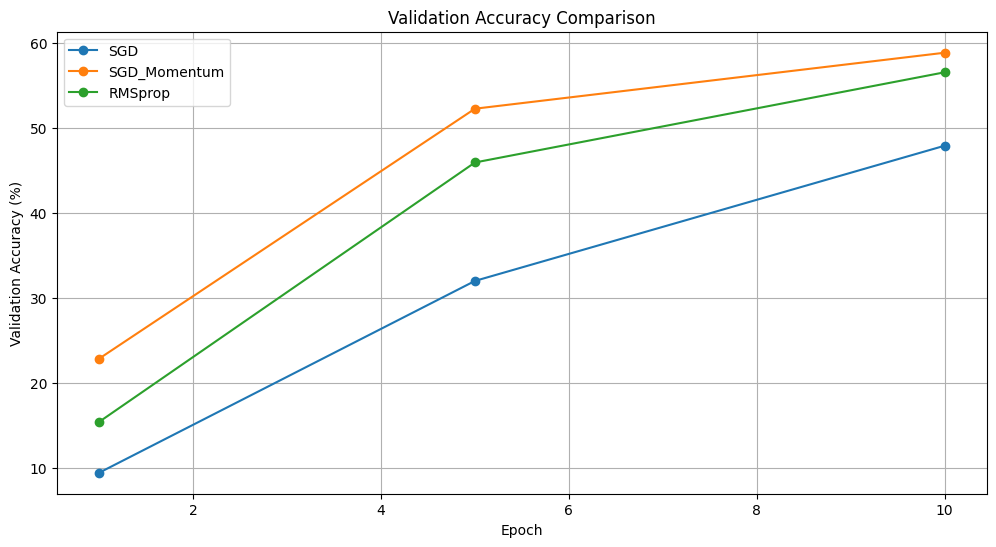

In [ ]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['RMSprop']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Training with optimizer: Adadelta

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 3.754, Val Loss: 3.352, Train Acc: 11.27%, Val Acc: 18.00%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 2.828, Val Loss: 2.530, Train Acc: 26.87%, Val Acc: 33.12%

Epoch 3

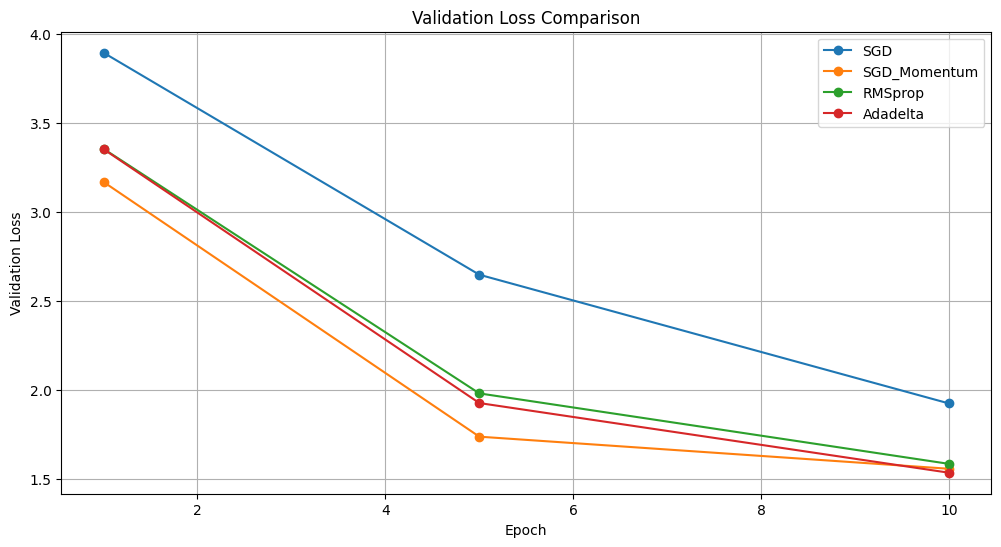

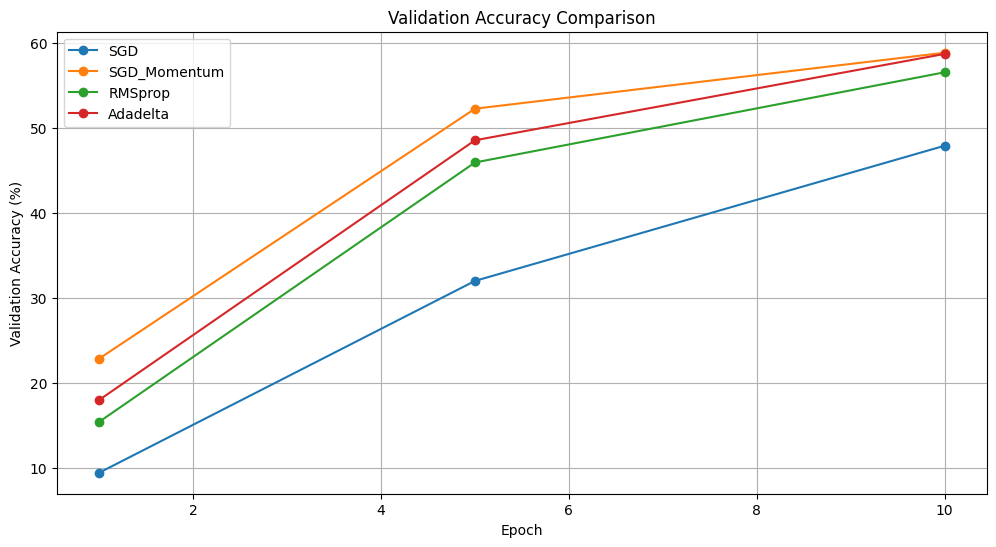

In [ ]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['Adadelta']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Training with optimizer: Adagrad

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 3.767, Val Loss: 3.258, Train Acc: 11.19%, Val Acc: 19.00%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 2.922, Val Loss: 2.628, Train Acc: 25.44%, Val Acc: 31.33%

Epoch 3

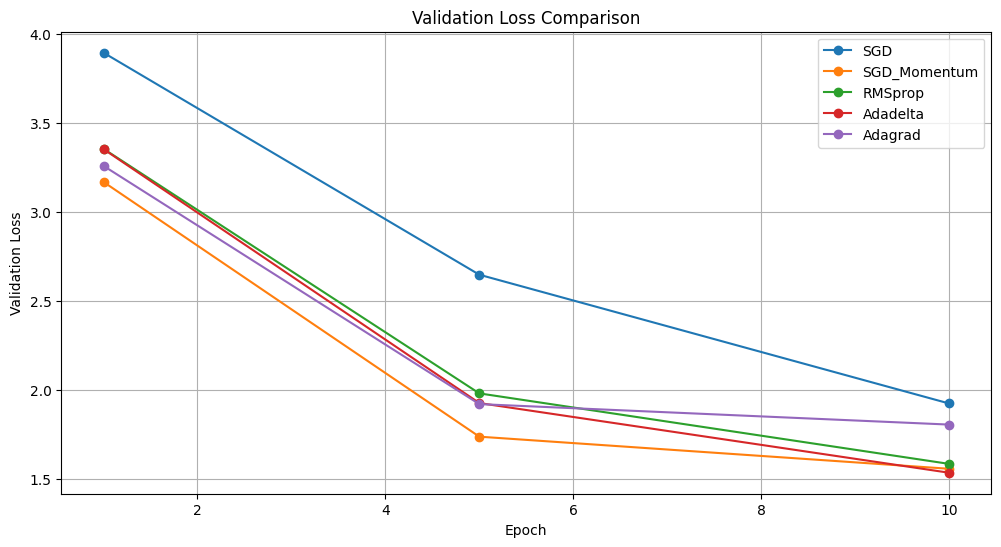

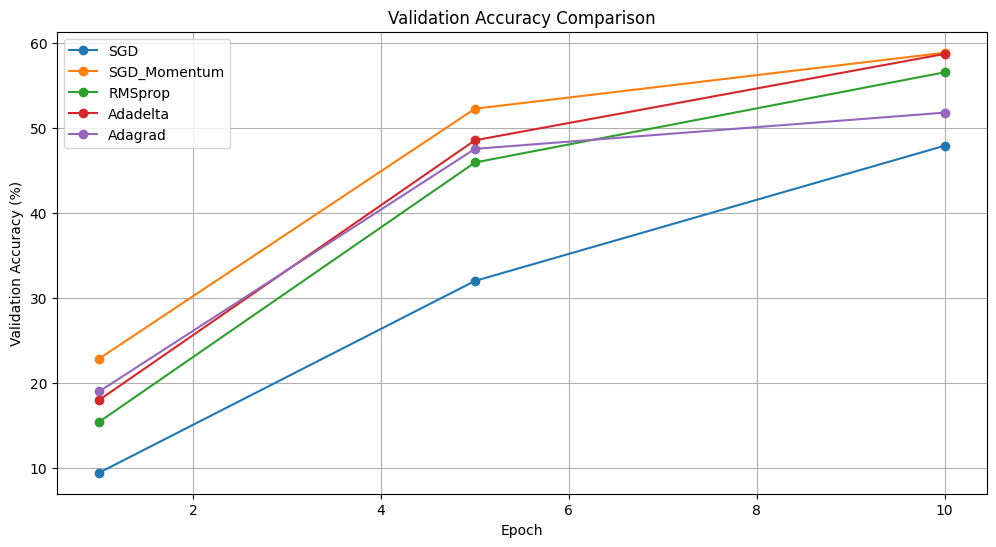

In [23]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['Adagrad']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Training with optimizer: Adam

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 1, Train Loss: 3.734, Val Loss: 3.240, Train Acc: 11.66%, Val Acc: 19.73%

Epoch 2/10
Progress: 10.0% completed for this epoch
Progress: 20.0% completed for this epoch
Progress: 29.9% completed for this epoch
Progress: 39.9% completed for this epoch
Progress: 49.9% completed for this epoch
Progress: 59.9% completed for this epoch
Progress: 69.9% completed for this epoch
Progress: 79.8% completed for this epoch
Progress: 89.8% completed for this epoch
Progress: 99.8% completed for this epoch
Epoch 2, Train Loss: 2.862, Val Loss: 2.674, Train Acc: 26.09%, Val Acc: 31.17%

Epoch 3

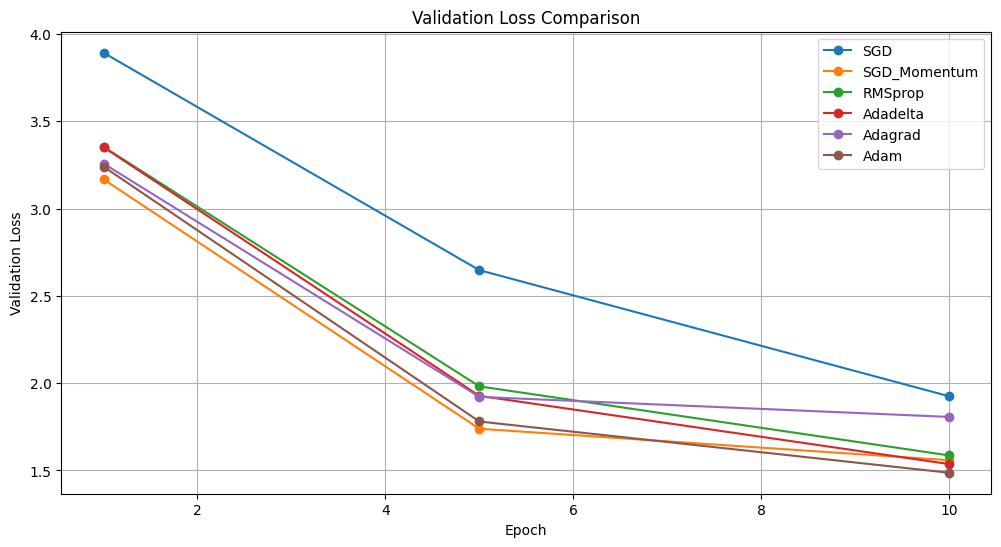

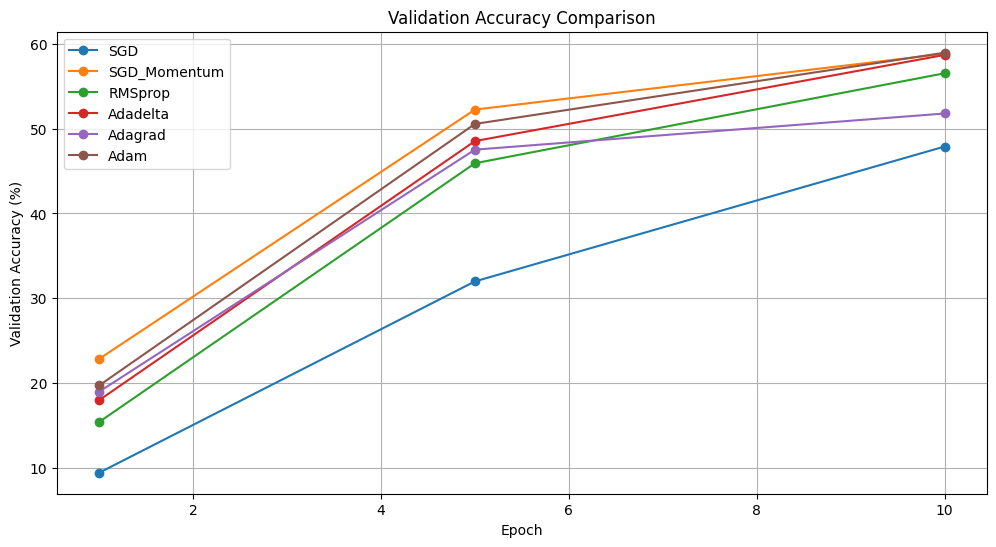

In [24]:
# Main execution
# To train optimizers one by one, set the optimizer you want to train below.
# After training one optimizer, you can comment it out and run the next one.

# Example: Train SGD optimizer
# Uncomment the optimizer you want to train and run the cell

# List of optimizers to train
# You can modify this list to include only the optimizer you want to train in this run
# For example, to train 'SGD', set optimizers_to_train = ['SGD']
optimizers_to_train = ['Adam']  # Change this list as needed

# Iterate through each selected optimizer and train the model
for opt_name in optimizers_to_train:
    if opt_name in optimizers_dict:
        train_model(opt_name, optimizers_dict[opt_name], num_epochs=10)
    else:
        print(f'Optimizer {opt_name} not found in the optimizers_dict.')

# After training all optimizers, you can load the results and display them
# Uncomment the following lines after all optimizers have been trained

# Load the accumulated results
results_df = pd.read_csv('optimizer_results/results.csv')
print("\nComparison of Optimizers:")
print(results_df)

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    losses = []
    if not pd.isna(row['Val Loss Epoch 1']):
        epochs.append(1)
        losses.append(row['Val Loss Epoch 1'])
    if not pd.isna(row['Val Loss Epoch 5']):
        epochs.append(5)
        losses.append(row['Val Loss Epoch 5'])
    if not pd.isna(row['Val Loss Epoch 10']):
        epochs.append(10)
        losses.append(row['Val Loss Epoch 10'])
    plt.plot(epochs, losses, marker='o', label=row['Optimizer'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    epochs = []
    accuracies = []
    if not pd.isna(row['Val Acc Epoch 1 (%)']):
        epochs.append(1)
        accuracies.append(row['Val Acc Epoch 1 (%)'])
    if not pd.isna(row['Val Acc Epoch 5 (%)']):
        epochs.append(5)
        accuracies.append(row['Val Acc Epoch 5 (%)'])
    if not pd.isna(row['Val Acc Epoch 10 (%)']):
        epochs.append(10)
        accuracies.append(row['Val Acc Epoch 10 (%)'])
    plt.plot(epochs, accuracies, marker='o', label=row['Optimizer'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()